패키지

In [1]:
import os
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

from PIL import Image


# ealry stopping
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

데이터

horse: 1454
human: 1436


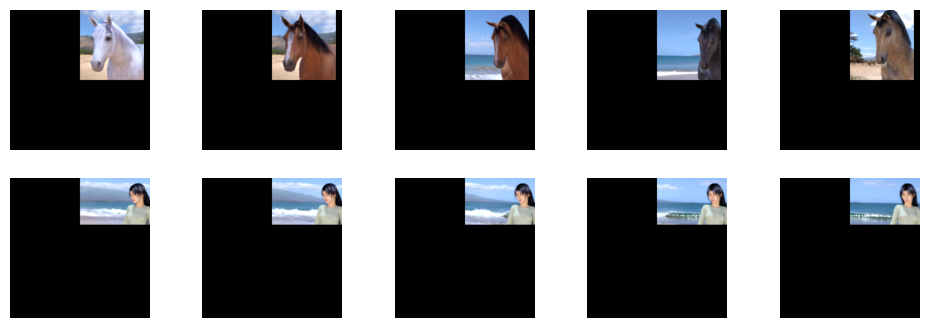

In [2]:
train_horse_dir = "./dataset/train_added/horses"
train_human_dir = "./dataset/train_added/humans"

train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

# 학습 데이터 리스트업
train_horse_names = os.listdir(train_horse_dir)
train_human_names = os.listdir(train_human_dir)

horse_files = [train_horse_dir + "/" + f for f in train_horse_names]
human_files = [train_human_dir + "/" + f for f in train_human_names]

# 학습 데이터의 개수 확인
print("horse:", len(train_horse_names))
print("human:", len(train_human_names))

# 데이터 미리보기
fig, axes = plt.subplots(2, 5, figsize=(12, 4))
ax = np.reshape(axes, -1)

for i, path in enumerate(horse_files[:5] + human_files[:5]):
    img = plt.imread(path)
    ax[i].axis("off")
    ax[i].imshow(img)

plt.show()

모델설계

In [3]:
# 모델 설계
model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Conv2D(
            16, (3, 3), activation="relu", input_shape=(300, 300, 3)
        ),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(32, (3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
        tf.keras.layers.MaxPool2D(2, 2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid"),
    ]
)

model.summary()

c:\Users\user\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 298, 298, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 149, 149, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 147, 147, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 5, 5, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 266,465 (1.02 MB)

 Trainable params: 266,465 (1.02 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
model.compile(
    loss="binary_crossentropy",
    optimizer=Adam(learning_rate=0.001),
    metrics=["accuracy"],
)

In [5]:
# 이미지 값을 0~1 사이로 제한
train_datagen = ImageDataGenerator(rescale=1 / 255)

# train set
train_generator = train_datagen.flow_from_directory(
    "./dataset/train_added/",
    target_size=(300, 300),  # 해상도 조절
    batch_size=128,  # 배치 크기
    class_mode="binary",  # 분류 방법
)

# valid set
valid_generator = train_datagen.flow_from_directory(
    "./dataset/validation/", target_size=(300, 300), batch_size=128, class_mode="binary"
)

# 끝까지 돌리지 않고 과적합이 일어나기 전 미리 멈추는 기능
es = EarlyStopping(
    monitor="loss", patience=3  # loss의 변동에 따라 학습을 더할지 그만할지를 결정
)

checkpoint = ModelCheckpoint(
    filepath="./checkpoint.keras", verbose=2, save_best_only=True, mode="auto"
)

# 모델 학습
history = model.fit(
    train_generator,
    steps_per_epoch=8,
    epochs=15,
    verbose=1,
    callbacks=[checkpoint, es],  # 위에서 정한 es,checkpoint를 적용하는 법
)

Found 2890 images belonging to 2 classes.
Found 256 images belonging to 2 classes.
Epoch 1/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 13s 898ms/step - accuracy: 0.5461 - loss: 0.6845
Epoch 2/15


c:\Users\user\anaconda3\Lib\site-packages\keras\src\callbacks\model_checkpoint.py:206: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 745ms/step - accuracy: 0.7413 - loss: 0.5450
Epoch 3/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 489ms/step - accuracy: 0.8843 - loss: 0.2711
Epoch 4/15


c:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 660ms/step - accuracy: 0.9537 - loss: 0.1396
Epoch 5/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 694ms/step - accuracy: 0.9209 - loss: 0.2088
Epoch 6/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 518ms/step - accuracy: 0.9507 - loss: 0.1296
Epoch 7/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 695ms/step - accuracy: 0.9730 - loss: 0.0843
Epoch 8/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 652ms/step - accuracy: 0.9799 - loss: 0.0587
Epoch 9/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 525ms/step - accuracy: 0.9689 - loss: 0.0944
Epoch 10/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 677ms/step - accuracy: 0.9788 - loss: 0.0788
Epoch 11/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 698ms/step - accuracy: 0.9798 - loss: 0.0551
Epoch 12/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 530ms/step - accuracy: 0.9787 - loss: 0.0650
Epoch 13/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 674ms/step - accuracy: 0.9975 - loss: 0.0273
Epoch 14/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 6s 696ms/step - accuracy: 0.9857 - loss: 0.0275
Epoch 15/15
8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 496ms/step - accuracy: 0.9906 - loss: 0.02

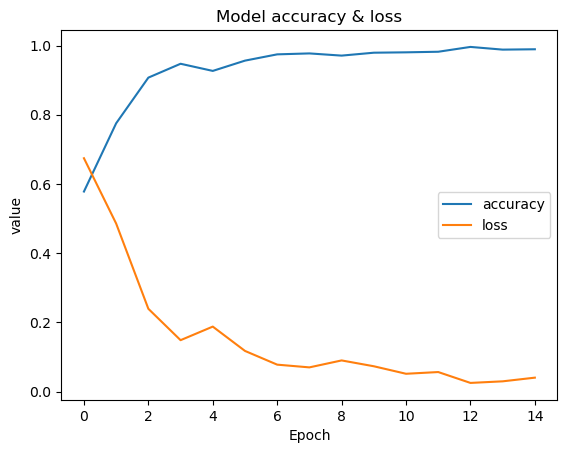

In [6]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.title("Model accuracy & loss")
plt.xlabel("Epoch")
plt.ylabel("value")
plt.legend(["accuracy", "loss"], loc="center right")
plt.show()

In [7]:
# 모델 검증
results = model.evaluate(valid_generator)
print("test loss, test acc:", results)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.7370 - loss: 1.8263
test loss, test acc: [1.8585646152496338, 0.73046875]


In [8]:
# 이미지 전처리
dlist = "./dataset/test/"
predict_list = os.listdir(dlist)
print(predict_list)

img = [cv2.imread(dlist + i) for i in predict_list]
img = [cv2.resize(i, (300, 300)) for i in img]
img = np.array(img)
img = img.astype("float32") / 255.0

# 분류
cutoff = 0.5
predictions = model.predict(img)
print(predictions >= cutoff)

['horse1.jpg', 'horse2.webp', 'horse3.jpg', 'human1.jpg', 'human2.jpg']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
[[False]
 [False]
 [ True]
 [False]
 [ True]]
